In [3]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
from typing import Optional
import numpy as np
import os
from strawberryfields.backends.tfbackend.states import FockStateTF
from math import exp
from src.utils import von_neumann_entropy, renyi_entropy

In [4]:
dir = 'logs/2023.02.21.13.19.23'
plots_path = os.path.join('./latex', 'figures')
os.makedirs(plots_path, exist_ok=True)
res = np.load(os.path.join(dir, 'results.npy'))
starting_distance = 0

binding_energies = res[:, starting_distance:, -1, -1]
states = res[:, starting_distance:, :-1, :-1]
distances = np.load(os.path.join(dir, 'distance_array.npy'))[starting_distance:]
thetas = np.load(os.path.join(dir, 'angle_array.npy'))
quadrature_grid = np.load(os.path.join(dir, 'quadrature_array.npy'))
entropy_array = von_neumann_entropy(states=states)
renyi_entropy_array = renyi_entropy(states=states, n=2)
correlation_array = np.load(os.path.join(dir, 'correlation_array.npy'))
bell_array = np.load(os.path.join(dir, 'bell_array.npy'))
startingDistance = [1, 2, 3, 5, 7, 8, 10, 12, 15, 18, 24, 22, 18, 17, 17, 16, 21, 25, 24] # starting at the first non-parallel angle

with open(os.path.join(dir, 'args.json')) as f:
    args = json.load(f)

In [12]:
states.shape

(20, 200, 5, 5)

In [25]:
traces = np.einsum('abcc->ab', np.einsum('abcd,abef->abcdef', states.conjugate(), states).reshape((20,200,25,25)))

In [31]:
distances[25]

0.5271356783919598

In [43]:
distances[9]

0.25376884422110557

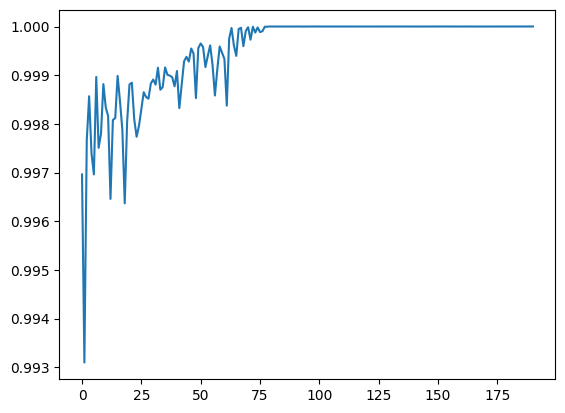

In [42]:
plt.plot(traces[7,9:])

In [16]:
rho = np.einsum('abml,abnl->abnm', states[:,25:,:,:].conjugate(), states[:,25:,:,:])

In [17]:
np.einsum('abcc->ab', rho).min()

(0.7883301578281765+0j)

In [11]:
def von_neumann_entropy(states: np.ndarray) -> np.ndarray:
    r""" Computes the von neumann entropy of a the partial density matrix
    of the first subsystem of the total system described by state `alpha`.
    Note that this function does not support more than a two-mode system for now.

    Args:
        alpha (np.ndarray): The coefficients of the state of the total system expressed in the Fock basis.
    Returns:
        (float): The von neumann entropy of the first subsystem.
    """

    # Let us compute the partial density matrix of the first
    # subsystem, expressed in the Fock basis
    rho = np.einsum('abml,abnl->abnm', states.conjugate(), states)

    entropy_array = np.zeros(shape=(states.shape[0], states.shape[1]))

    # Unfortunately the log of a matrix is computed with `linalg.logm`,
    # which doesn't have a vectorized implementation, so one should loop.
    for i in range(entropy_array.shape[0]):
        for j in range(entropy_array.shape[1]):

            # We finally compute the von Neumann entropy (log base 2)
            entropy = - (1 / log(2)) * np.trace(rho[i, j] @ linalg.logm(rho[i, j]))
            entropy_array[i, j] = entropy

    return entropy_array

In [7]:
import numpy as np
from scipy import linalg

def von_neumann_entropy(alpha: np.ndarray) -> np.ndarray:
    r""" Computes the von neumann entropy of a the partial density matrix
    of the first subsystem of the total system described by state `alpha`.
    Note that this function does not support more than a two-mode system for now.

    Args:
        alpha (np.ndarray): The coefficients of the state of the total system expressed in the Fock basis.
    Returns:
        (np.ndarray): The von neumann entropy of the first subsystem.
    """

    # Let us compute the partial density matrix of the first
    # subsystem, expressed in the Fock basis
    rho = np.einsum('ml,nl->nm', alpha.conjugate(), alpha)

    # We finally compute the von Neumann entropy
    entropy = -np.trace(rho @ linalg.logm(rho))

    return entropy

In [2]:
alpha = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ]
)


In [21]:
type(von_neumann_entropy(alpha=alpha).item())

float

In [9]:
rho = np.einsum('ml,nl->nm', alpha.conjugate(), alpha)

In [9]:
import itertools
dim1 = 2
dim2 = 4

input = ((i, j) for i, j in itertools.product(range(dim1), range(dim2)))
print(list(input))

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]


In [38]:
alpha = np.zeros(shape=(9, 70, 5, 5))

In [23]:
a = np.array(results).reshape((2, 3, 2, 2))

In [27]:
a[1, 2]

array([[ 1,  3],
       [-1,  2]])

In [5]:
import numpy as np
import string


In [8]:
a = np.array([[1, 2], [3, 4]])
n = 3

In [33]:
einsum_rule = ','.join([string.ascii_lowercase[n+1] + string.ascii_lowercase[n+2] + string.ascii_lowercase[i: i+2] for i in range(n)]) + '->' + string.ascii_lowercase[0] +string.ascii_lowercase[n]
np.einsum(einsum_rule, *(a for _ in range(n)))

array([[ 37,  54],
       [ 81, 118]])

In [37]:
einsum_rule = ','.join([string.ascii_lowercase[n+1] + string.ascii_lowercase[n+2] + string.ascii_lowercase[i: i+2] for i in range(n)]) + '->' + string.ascii_lowercase[n+1] + string.ascii_lowercase[n+2] + string.ascii_lowercase[0] + string.ascii_lowercase[n]
einsum_rule

'efab,efbc,efcd->efad'

In [39]:
from src.utils import renyi_entropy

renyi_entropy(alpha)

ModuleNotFoundError: No module named 'strawberryfields'

In [2]:
import numpy as np
from strawberryfields import ops
from strawberryfields.program import Program
from strawberryfields.program_utils import RegRef
from typing import List

class VQE():

    def __init__(
        self,
        layers: int,
        distance: float,
        theta: float,
        x_quadrature_grid: np.ndarray,
        atoms: List[Atom],
        active_sd: float = 0.0001,
        passive_sd: float = 0.1,
        cutoff_dim: int = 6,
        learning_rate: float = 0.001,
        save_dir: str = 'logs/',
        verbose: bool = True
    ) -> None:
        """
        Initializes a new instance of the QuantumNeuralNetwork class.

        Args:
            layers (int): The number of layers in the quantum neural network.
            distance (float): Distance between the two QDOs.
            order (str): Order in the multipolar expansion: `quadratic`, `quartic` or `full`.
            theta (float): Angle with respect to the axis connecting the two nuclei. Defines the 1d model.
            atoms (List[Atom]): List of atoms, characterized by their mass, frequency and charge.
            active_sd (float): The standard deviation of the active weights.
            passive_sd (float): The standard deviation of the passive weights.
            cutoff_dim (int): The cutoff dimension of the quantum engine.
            learning_rate (float): The learning rate for the tensorflow optimizer.
            save_dir (str): Directory where to save the logs.

        Returns:
            None
        """

        self.dimension = 1
        self.modes = len(atoms) * self.dimension
        self.layers = layers
        self.cutoff_dim = cutoff_dim
        self.distance = distance
        self.theta = theta
        self.atoms = atoms
        self.save_dir = save_dir
        self.verbose = verbose

        self.eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": self.cutoff_dim})
        self.qnn = sf.Program(self.modes)

        self.weights = self.init_weights(active_sd=active_sd, passive_sd=passive_sd) # our TensorFlow weights
        num_params = np.prod(self.weights.shape)   # total number of parameters in our model

        self.sf_params = np.arange(num_params).reshape(self.weights.shape).astype(np.str)
        self.sf_params = np.array([self.qnn.params(*i) for i in self.sf_params])

        self.circuit = Circuit(self.qnn, self.sf_params, self.layers)

        self.best_loss = None
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_history = None
        self.state = None
        self.density = None
        self.marginals = None
        self.partial_entropy = None

        # Define the discretize position quadrature line/grid.
        self.x = tf.cast(tf.constant(x_quadrature_grid), tf.double)

    def init_weights(
        self,
        active_sd: float = 0.0001,
        passive_sd: float = 0.1
    ) -> None:
        """Initialize a 2D TensorFlow Variable containing normally-distributed
        random weights for an ``N`` mode quantum neural network with ``L`` layers.

        Args:
            active_sd (float): the standard deviation used when initializing
                the normally-distributed weights for the active parameters
                (displacement, squeezing, and Kerr magnitude)
            passive_sd (float): the standard deviation used when initializing
                the normally-distributed weights for the passive parameters
                (beamsplitter angles and all gate phases)

        Returns:
            tf.Variable[tf.float32]: A TensorFlow Variable of shape
            ``[layers, 2*(max(1, modes-1) + modes**2 + modes)]``, where the Lth
            row represents the layer parameters for the Lth layer.
        """

        # Number of interferometer parameters:
        M = int(self.modes * (self.modes - 1)) + max(1, self.modes - 1)

        # Create the TensorFlow variables
        int1_weights = tf.random.normal(shape=[self.layers, M], stddev=passive_sd)
        s_weights = tf.random.normal(shape=[self.layers, self.modes], stddev=active_sd)
        int2_weights = tf.random.normal(shape=[self.layers, M], stddev=passive_sd)
        dr_weights = tf.random.normal(shape=[self.layers, self.modes], stddev=active_sd)
        dp_weights = tf.random.normal(shape=[self.layers, self.modes], stddev=passive_sd)
        k_weights = tf.random.normal(shape=[self.layers, self.modes], stddev=active_sd)

        weights = tf.concat(
            [int1_weights, s_weights, int2_weights, dr_weights, dp_weights, k_weights], axis=1
        )

        weights = tf.Variable(weights)

        return weights

    def cost(
        self,
        state: FockStateTF
    ) -> tf.Tensor:
        """
        Calculates the cost of a given Fock state using the Hamiltonian function.
        We treat either the full Coulomb potential Hamiltonian, or the Hamiltonian
        at some fixed order in the multipolar expansion.

        Args:
            state (FockStateTF): The Fock state for which to calculate the cost.

        Returns:
            tf.Tensor: The cost of the given Fock state.
        """

        # Define the discretize position quadrature line/grid.
        x = self.x
        # Store the qudrature step playing the role of 'integration measure'.
        dx = (x[1] - x[0]).numpy()
        # Store the total number of values in the quadrature grid.
        L = x.shape[0]

        # Compute the joint probablity density of the quadratures
        # by calling `src.utils.quadrature_density`
        density = quadratures_density(
            x=x,
            alpha=state.ket(),
            num_modes=self.modes,
            cutoff=self.cutoff_dim
        )

        density = tf.cast(density, tf.double)

        # Compute the mean photon number for each photon channel
        # in the system and concatenate them.
        n = tf.reshape(
            tf.stack([state.mean_photon(mode=i, cutoff=self.cutoff_dim)[0] for i in range(self.modes)]),
            shape=(self.modes,)
        )

        n = tf.cast(n, tf.double)

        # Store the QDO parameters
        m1 = self.atoms[0].m
        m2 = self.atoms[1].m
        q1 = self.atoms[0].q
        q2 = self.atoms[1].q
        omega1 = self.atoms[0].omega
        omega2 = self.atoms[1].omega

        # Since the quadratures we are working with in Strawberry Fields are
        # dimensionless, the following dimensionful parameters have to appear explicitely
        # in the definition of the various potentials below.
        a1 = sqrt(sf.hbar / (m1 * omega1))
        a2 = sqrt(sf.hbar / (m2 * omega2))

        ct = cos(self.theta)

        potential = q1 * q2 * (
            1 / self.distance \
            - 1 / tf.sqrt(self.distance**2 + 2 * ct * a1 * self.distance * tf.repeat(x[:,tf.newaxis], L, 1) + a1**2 * tf.repeat((x**2)[:,tf.newaxis], L, 1)) \
            - 1 / tf.sqrt(self.distance**2 - 2 * ct * a2 * self.distance * tf.repeat(x[tf.newaxis,:], L, 0) + a2**2 * tf.repeat((x**2)[tf.newaxis,:], L, 0)) \
            + 1 / tf.sqrt(self.distance**2 - 2 * ct * self.distance * (a2 * tf.repeat(x[tf.newaxis,:], L, 0) - a1 * tf.repeat(x[:,tf.newaxis], L, 1)) + a1**2 * tf.repeat((x**2)[:,tf.newaxis], L, 1) + a2**2 * tf.repeat((x**2)[tf.newaxis,:], L, 0) - 2 * a1 * a2 * tf.einsum('a,b->ab', x, x))
        )
        potential_expectation = tf.einsum('ab,ab->', dx**self.modes * density, potential)
        cost = sf.hbar * omega1 * (n[0] + 0.5) + sf.hbar * omega2 * (n[1] + 0.5) + potential_expectation

        return cost

    def train(
        self,
        epsilon=1e-3,
        patience=20
    ) -> None:
        r"""
        Args:
            epsilon (float): Tolerance for the training loop stopping criterium.
            alpha (float): Rate for the moving average in the training loop.
            patience (int): Impose lack of improvement in loss for at least that number of epochs.

        Returns:
            None
        """

        prev_loss = float('inf')
        cpt = 0
        patience_cpt = 0

        self.loss_history = []
        self.loss_history_average = []

        while True:

            # Reset the engine
            if self.eng.run_progs:
                self.eng.reset()

            # Compute the loss
            with tf.GradientTape() as tape:
                mapping = {p.name: w for p, w in zip(self.sf_params.flatten(), tf.reshape(self.weights, [-1]))}
                state = self.eng.run(self.qnn, args=mapping).state
                loss = self.cost(state)

            # Check if `epsilon`-improvement or not. If no improvement during
            # at least `patience` epochs, break the training loop.
            if np.abs(prev_loss - loss) < epsilon:
                if (cpt + 1) % 5 == 0:
                    patience_cpt += 1
            else:
                patience_cpt = 0
            if patience_cpt >= patience or cpt >= 500:
                break

            # Perform the classical optimization step
            gradients = tape.gradient(loss, self.weights)
            self.optimizer.apply_gradients(zip([gradients], [self.weights]))
            self.loss_history.append(float(loss))
            #self.loss_history_average.append(float(avg_loss))

#            prev_loss = avg_loss

            cpt += 1

            if self.verbose:
                if (cpt + 1) % 10 == 0:
                    #print("Epoch {:03d} | Loss {:.6f} | Running average loss {:.6f}".format(cpt, loss, avg_loss))
                    print("Epoch {:03d} | Loss {:2.6f} | Patience_cpt {} | diff {:2.6f} | Angle {} | Distance {}".format(cpt, loss, patience_cpt, np.abs(prev_loss - loss), self.theta, self.distance))

            prev_loss = loss
        # Compute the necessary logs and store them in attributes
        # The value of the loss at the end of the training,
        # namely the ground state energy of the system.
        self.best_loss = self.loss_history[-1]

        # The ground state \alpha of the system, expressed as \sum_{mn}^cutoff \alpha_{mn} |m, n>
        # in the case of two modes, and obvious generalization for 6 modes.
        # Useful to keep it to maybe plot marginal Wigner functions.
        self.state = state


class Circuit():

    def __init__(
        self,
        qnn: Program,
        sf_params: np.ndarray,
        layers: int
    ) -> None:

        """Constructor method of the Circuit class.

        This method initializes the object with the given quantum neural network `qnn`,
        the array of `sf_params` parameters, and the number of `layers` in the neural network.

        Args:
            qnn (Program): The quantum neural network.
            sf_params (np.ndarray): An array of parameters for the scaling and squeezing transformations.
            layers (int): The number of layers in the quantum neural network.

        Returns:
            None
        """

        self.qnn = qnn
        self.sf_params = sf_params

        with self.qnn.context as q:
            for k in range(layers):
                self.layer(sf_params[k], q)

    def interferometer(
        self,
        params: List[float],
        q: List[RegRef]
    ) -> None:
        """Parameterised interferometer acting on ``N`` modes.

        Args:
            params (list[float]): list of length ``max(1, N-1) + (N-1)*N`` parameters.

                * The first ``N(N-1)/2`` parameters correspond to the beamsplitter angles
                * The second ``N(N-1)/2`` parameters correspond to the beamsplitter phases
                * The final ``N-1`` parameters correspond to local rotation on the first N-1 modes

            q (list[RegRef]): list of Strawberry Fields quantum registers the interferometer
                is to be applied to
        """

        N = len(q)
        theta = params[:N*(N-1)//2]
        phi = params[N*(N-1)//2:N*(N-1)]
        rphi = params[-N+1:]

        if N == 1:
            # the interferometer is a single rotation
            ops.Rgate(rphi[0]) | q[0]
            return

        n = 0  # keep track of free parameters

        # Apply the rectangular beamsplitter array
        # The array depth is N
        for l in range(N):
            for k, (q1, q2) in enumerate(zip(q[:-1], q[1:])):
                # skip even or odd pairs depending on layer
                if (l + k) % 2 != 1:
                    ops.BSgate(theta[n], phi[n]) | (q1, q2)
                    n += 1

        # apply the final local phase shifts to all modes except the last one
        for i in range(max(1, N - 1)):
            ops.Rgate(rphi[i]) | q[i]

    def layer(
        self,
        params: List[float],
        q: List[RegRef]
    ) -> None:
        """CV quantum neural network layer acting on ``N`` modes.

        Args:
            params (list[float]): list of length ``2*(max(1, N-1) + N**2 + n)`` containing
                the number of parameters for the layer
            q (list[RegRef]): list of Strawberry Fields quantum registers the layer
                is to be applied to
        """
        N = len(q)
        M = int(N * (N - 1)) + max(1, N - 1)

        int1 = params[:M]
        s = params[M:M+N]
        int2 = params[M+N:2*M+N]
        dr = params[2*M+N:2*M+2*N]
        dp = params[2*M+2*N:2*M+3*N]
        k = params[2*M+3*N:2*M+4*N]

        # begin layer
        self.interferometer(int1, q)

        for i in range(N):
            ops.Sgate(s[i]) | q[i]

        self.interferometer(int2, q)

        for i in range(N):
            ops.Dgate(dr[i], dp[i]) | q[i]
            ops.Kgate(k[i]) | q[i]

NameError: name 'Atom' is not defined

In [ ]:
eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": self.cutoff_dim})
qnn = sf.Program(self.modes)